In [ ]:
!rocm-smi



========================================= ROCm System Management Interface =========================================
=================================================== Concise Info ===================================================
Device  Node  IDs              Temp    Power  Partitions          SCLK    MCLK     Fan  Perf  PwrCap  VRAM%  GPU%  
              (DID,     GUID)  (Edge)  (Avg)  (Mem, Compute, ID)                                                   
0       4     0x740c,   57586  44.0°C  88.0W  N/A, N/A, 0         800Mhz  1600Mhz  0%   auto  560.0W  5%     0%    
1       5     0x740c,   45873  43.0°C  N/A    N/A, N/A, 0         800Mhz  1600Mhz  0%   auto  0.0W    5%     0%    
2       2     0x740c,   14571  38.0°C  92.0W  N/A, N/A, 0         800Mhz  1600Mhz  0%   auto  560.0W  7%     0%    
3       3     0x740c,   27432  34.0°C  N/A    N/A, N/A, 0         800Mhz  1600Mhz  0%   auto  0.0W    5%     0%    
4       8     0x740c,   30939  39.0°C  94.0W  N/A, N/A, 0         80

In [ ]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [ ]:
import torch

print(torch.cuda.is_available())

for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_properties(i))

True
_CudaDeviceProperties(name='AMD Instinct MI250X/MI250', major=9, minor=0, gcnArchName='gfx90a:sramecc+:xnack-', total_memory=65520MB, multi_processor_count=104, uuid=38363933-6532-6639-6638-643438353066, L2_cache_size=8MB)
_CudaDeviceProperties(name='AMD Instinct MI250X/MI250', major=9, minor=0, gcnArchName='gfx90a:sramecc+:xnack-', total_memory=65520MB, multi_processor_count=104, uuid=61303265-6137-3733-3161-313839323838, L2_cache_size=8MB)
_CudaDeviceProperties(name='AMD Instinct MI250X/MI250', major=9, minor=0, gcnArchName='gfx90a:sramecc+:xnack-', total_memory=65520MB, multi_processor_count=104, uuid=38356530-3739-3264-3035-646631353033, L2_cache_size=8MB)
_CudaDeviceProperties(name='AMD Instinct MI250X/MI250', major=9, minor=0, gcnArchName='gfx90a:sramecc+:xnack-', total_memory=65520MB, multi_processor_count=104, uuid=32356634-3338-3763-3932-633762333235, L2_cache_size=8MB)
_CudaDeviceProperties(name='AMD Instinct MI250X/MI250', major=9, minor=0, gcnArchName='gfx90a:sramecc+:

In [4]:
from datasets import load_dataset

dataset = load_dataset("nilc-nlp/assin2")

dataset

DatasetDict({
    train: Dataset({
        features: ['sentence_pair_id', 'premise', 'hypothesis', 'relatedness_score', 'entailment_judgment'],
        num_rows: 6500
    })
    test: Dataset({
        features: ['sentence_pair_id', 'premise', 'hypothesis', 'relatedness_score', 'entailment_judgment'],
        num_rows: 2448
    })
    validation: Dataset({
        features: ['sentence_pair_id', 'premise', 'hypothesis', 'relatedness_score', 'entailment_judgment'],
        num_rows: 500
    })
})

In [ ]:
model_name = "answerdotai/ModernBERT-base"

In [6]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name)

def preprocess(example):
    return tokenizer(example["premise"], 
                     example["hypothesis"], 
                     truncation=True, 
                     padding="max_length", 
                     max_length=512)

encoded_dataset = dataset.map(preprocess, batched=True)

encoded_dataset = encoded_dataset.rename_column("entailment_judgment", "labels")

encoded_dataset = encoded_dataset.remove_columns(["sentence_pair_id", "relatedness_score"])

encoded_dataset.set_format(type="pt", columns=["input_ids", "attention_mask", "labels"])

encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 6500
    })
    test: Dataset({
        features: ['premise', 'hypothesis', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 2448
    })
    validation: Dataset({
        features: ['premise', 'hypothesis', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 500
    })
})

In [7]:
from transformers import ModernBertForSequenceClassification

model = ModernBertForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=2,
)

model

You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.
Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ModernBertForSequenceClassification(
  (model): ModernBertModel(
    (embeddings): ModernBertEmbeddings(
      (tok_embeddings): Embedding(50368, 768, padding_idx=50283)
      (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (drop): Dropout(p=0.0, inplace=False)
    )
    (layers): ModuleList(
      (0): ModernBertEncoderLayer(
        (attn_norm): Identity()
        (attn): ModernBertAttention(
          (Wqkv): Linear(in_features=768, out_features=2304, bias=False)
          (rotary_emb): ModernBertUnpaddedRotaryEmbedding(dim=64, base=160000.0, scale_base=None)
          (Wo): Linear(in_features=768, out_features=768, bias=False)
          (out_drop): Identity()
        )
        (mlp_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): ModernBertMLP(
          (Wi): Linear(in_features=768, out_features=2304, bias=False)
          (act): GELUActivation()
          (drop): Dropout(p=0.0, inplace=False)
          (Wo): Linear(in_features=1152, 

In [8]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)  # Convert logits to class predictions

    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="macro")
    
    return {"accuracy": acc, "macro_f1": f1}


In [9]:
from transformers import TrainingArguments, Trainer
from transformers import get_wsd_schedule
from torch.optim import AdamW

total_steps = 10_000

training_args = TrainingArguments(
    output_dir=f"./training/RTE/{model_name}",

    max_steps=total_steps,

    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,

    save_strategy="steps",
    save_steps=100,
    save_total_limit=10,

    eval_strategy="steps",  
    eval_steps=100,

    logging_strategy="steps",
    logging_first_step=True, 
    logging_steps=100,

    logging_dir=f"./rte-logs/{model_name}",
    report_to=["tensorboard"],

    learning_rate=1e-5,
    weight_decay=1e-4,

    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",  # computed by compute metrics()
    greater_is_better=True, # Greater is better for f1

    # fp16=True,
)

optimizer = AdamW(
    model.parameters(), 
    lr=training_args.learning_rate,
    weight_decay=training_args.weight_decay,
)

# lr_scheduler = get_wsd_schedule(
#     optimizer=optimizer,
#     num_warmup_steps= training_args.max_steps * 0.1,
#     num_stable_steps= training_args.max_steps * 0.3,
#     num_decay_steps= training_args.max_steps * 0.6,
#     min_lr_ratio= 0,
#     num_cycles= 0.5,
# )

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    compute_metrics=compute_metrics,
    # optimizers=(optimizer, lr_scheduler),
)

In [10]:
torch.cuda.empty_cache()

trainer.train()

/share/sw/ai/pytorch/2.5.1/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,Macro F1
100,0.546000,0.377805,0.836000,0.836000
200,0.426800,0.346601,0.830000,0.829256
300,0.322400,0.275982,0.884000,0.883954
400,0.280500,0.273244,0.888000,0.887971
500,0.211700,0.250236,0.886000,0.885799
600,0.189400,0.237629,0.900000,0.899960
700,0.116700,0.261376,0.916000,0.915988
800,0.103000,0.259326,0.908000,0.907928
900,0.077700,0.274613,0.912000,0.911886
1000,0.074400,0.309951,0.916000,0.915966


/share/sw/ai/pytorch/2.5.1/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/share/sw/ai/pytorch/2.5.1/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/share/sw/ai/pytorch/2.5.1/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/share/sw/ai/pytorch/2.5.1/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/share/sw/ai/pytorch/2.5.1/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; w

TrainOutput(global_step=10000, training_loss=0.027978860914334654, metrics={'train_runtime': 4821.3891, 'train_samples_per_second': 66.371, 'train_steps_per_second': 2.074, 'total_flos': 1.0857499096038605e+17, 'train_loss': 0.027978860914334654, 'epoch': 49.01960784313726})

In [11]:
results = trainer.evaluate(encoded_dataset["test"])

print(results)

/share/sw/ai/pytorch/2.5.1/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 1.9621987342834473, 'eval_accuracy': 0.8116830065359477, 'eval_macro_f1': 0.8109249969716916, 'eval_runtime': 18.0713, 'eval_samples_per_second': 135.463, 'eval_steps_per_second': 4.261, 'epoch': 49.01960784313726}


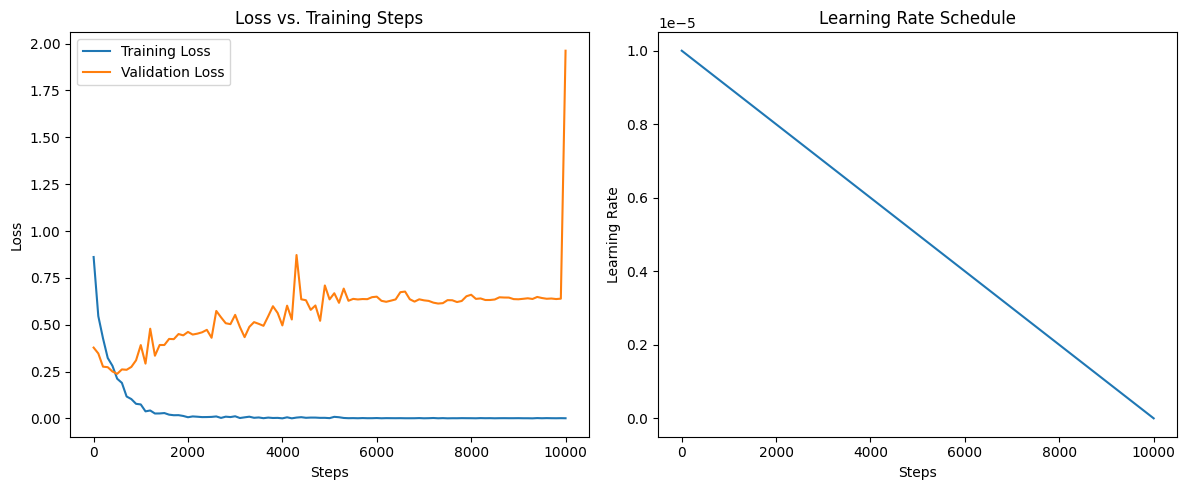

In [12]:
import matplotlib.pyplot as plt

logs = trainer.state.log_history

train_loss = []
eval_loss = []
learning_rates = []
steps = []

for entry in logs:
    if "loss" in entry and "epoch" in entry:
        train_loss.append(entry["loss"])
        steps.append(entry["step"])
    if "eval_loss" in entry:
        eval_loss.append(entry["eval_loss"])
    if "learning_rate" in entry:
        learning_rates.append(entry["learning_rate"])

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(steps, train_loss, label="Training Loss")
if eval_loss:
    # eval_loss is per epoch — fewer points
    plt.plot(
        steps[:len(eval_loss)],  # align epochs to steps if possible
        eval_loss,
        label="Validation Loss"
    )
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Loss vs. Training Steps")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(steps[:len(learning_rates)], learning_rates)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")

plt.tight_layout()
plt.show()

In [13]:
from torch.utils.data import DataLoader
import torch

loader = DataLoader(encoded_dataset["test"], batch_size=8)

model.eval()
examples = []

with torch.no_grad():
    for batch in loader:
        input_ids = batch["input_ids"].to(model.device)
        attention_mask = batch["attention_mask"].to(model.device)
        labels = batch["labels"].to(model.device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)

        for inp_ids, pred, label in zip(input_ids, predictions, labels):
            text_pair = tokenizer.decode(inp_ids, skip_special_tokens=False)
            examples.append((text_pair, pred.item(), label.item()))

        if len(examples) >= 5:
            break

# Pretty print examples
for i, (text_pair, pred, label) in enumerate(examples[:5]):
    print(f"Example {i+1}")
    print(f"📝 Sentence Pair: {text_pair}")
    print(f"📊 Predicted Label: {pred} ({'Entailment' if pred==1 else 'Not Entailment'})")
    print(f"✅ Ground Truth: {label} ({'Entailment' if label==1 else 'Not Entailment'})")
    print("-" * 50)


Example 1
📝 Sentence Pair: [CLS]O cachorro caramelo está assistindo um cachorro castanho que está nadando em uma lagoa[SEP]Um cachorro de estimação está de pé no banco e está olhando outro cachorro, que é castanho, na lagoa[SEP][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][P